In [48]:
import sys
sys.path.append('../../')
import glob
from tqdm import tqdm

import ROOT 
from ROOT import TFile

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from numpy_indexed import group_by

from particle import Particle
from g4mu.utils.sorting import *
from g4mu.utils.plotting_magic import *


import matplotlib.pyplot as plt
from matplotlib import ticker

### Settings

In [2]:
# Process charged secondaries below this energy
energy_cut = 0.5 # GeV

# Refractive index (assume wavelength-independent)
n_refr = 1.33

# Processes in which the secondaries were generated
extract_processes = ['muIoni', 'muPairProd', 'muonNuclear', 'muBrems']

# Placeholder for the secondary particle records
secondary_data = {}
for process in extract_processes:
    secondary_data[process] = []

### Find ROOT files

In [3]:
# Get the file names of the Geant4 sim output trees
input_files = glob.glob('../output/icesim_*.root')
input_files.sort(key=natural_keys)

### Process ROOT files and extract secondary track lengths 

In [4]:
# Loop through the files
for file_path in input_files:
    print('Processing file %s'%file_path)
    # Get the ROOT tree and its branches
    inp = TFile(file_path)
    ttree = inp.Get("muons_in_ice")
    branches = np.array(ttree.GetListOfBranches())
    branch_names = [branches[i].GetName() for i in range(len(branches))]
    # Get the number of events in the current file
    n_entries = ttree.GetEntries()
    print('Found %s events'%n_entries)
    
    # Loop through the events in the current file
    
    for i in tqdm(range(n_entries)):
        # Get the tree data for the current event
        ttree.GetEntry(i)
        # PDG IDs of the track-generating particles (e.g. muon, electron...)
        track_pids = np.array(ttree.pid).astype(int)
        # Unique Geant4 track IDs
        track_ids = np.array(ttree.tid).astype(int)
        # Track IDs of the track parents
        parent_track_ids = np.array(ttree.parid).astype(int)
        
        # List of all processes (str)
        process_names_list = list(ttree.proc)
        process_names = np.array([str(process_names_list[j]) for j in range(len(process_names_list))])
        
        # Track lengths of the secondary particles
        secondary_track_lengths = np.array(ttree.track_length).astype(float)
        
        # Kinetic energies of the secondary particles
        secondary_ekin = np.array(ttree.ekin).astype(float)

        # Each track contains multiple propagation steps. We need to group the tree data by tracks using track IDs:
        grouping = group_by(track_ids)
        # The PID of the track-generating particle
        grouped_pids = grouping.first(track_pids)[1]
        # The track ID of the current track's parent
        grouped_parent_ids = grouping.first(parent_track_ids)[1]
        # The track ID of the current track
        grouped_track_ids = grouping.first(track_ids)[1]
        # The process in which the track-generating particle was originally created
        grouped_processes = grouping.first(process_names)[1]
        # The initial kinetic energy of the secondary is the maximum energy of the track
        # (as the secondary loses energy over the propagation steps stored in the track)
        grouped_ekin = grouping.max(secondary_ekin)[1]
        # The total track length is the max of the track lengths stored in propagation steps
        # (what is stored in each step is the cumulative track length value, so we just need the final one)
        grouped_track_lengths = grouping.max(secondary_track_lengths)[1]

        # Total muon track length in meters
        muon_track_length_m = float(grouped_track_lengths[grouped_pids == 13][0]) / 1e3
        # Total muon kinetic energy in GeV
        muon_energy_gev = np.array(ttree.ekini)[0]
        
        # It is possible that some electrons were created not as the result of direct muon ionization,
        # but as the result of electron ionization ('eIoni' process), where the parent electron is created in 'muIoni'.
        # Therefore we need to search not only over parent processes, but also over "grantparent" processes 
        # (otherwise we will not get any contributions from the tetriary particles and the total track length sum
        # over the "secondaries" will be underestimated).
        # To get the grandparent's process, create a lookup table over the track IDs (this is MUCH faster than np.where search!)
        track_dict = {grouped_track_ids[x]: x for x in range(len(grouped_track_ids))}
        # The first parent is a muon and was not created in any processes, so we just append a 'None' at the beginning
        parent_processes = np.append('None', grouped_processes[np.array([track_dict[parent] for parent in grouped_parent_ids[1:]])])
        
        
        for process in extract_processes:
        # Select low-energy electrons that were generated in one of the muon processes.
        # The try-except statement prevents us from not finding any particles that satisfy the requested
        # criteria and getting IndexErrors.
            try:
                # We search for an electron/positron in all processes but the muon nuclear interaction
                if process != 'muonNuclear':
                    daughter_pid = 11
                    mask = (np.abs(grouped_pids) == daughter_pid) & (grouped_ekin < energy_cut) & \
                            ((grouped_processes == process) | (parent_processes == process))
                # Otherwise, we search for any charged particles (hadrons)
                else:
                    mask = (grouped_ekin < energy_cut) & ((grouped_processes == process) | (parent_processes == process)) \
                    & (grouped_pids != 22)
                    daughter_pid = grouped_pids[mask][0]
                # The mass of the daughter
                daughter_mass = Particle.from_pdgid(daughter_pid).mass / 1e3
                # The kinetic energy of the daughter
                daughter_ekin = grouped_ekin[mask]
                # The total energy of the daughter
                daughter_etot = daughter_ekin + daughter_mass
                # Lorentz gamma
                daughter_gamma = daughter_etot / daughter_mass
                # Lorentz beta
                daughter_beta = np.sqrt(1 - (1 / daughter_gamma)**2)
                # Frank-Tamm correction factors as per https://arxiv.org/pdf/1206.5530.pdf
                frank_tamm_factors = (1 - (1 / (n_refr * daughter_beta) ** 2)) / (1 - (1 / n_refr**2))
                frank_tamm_factors = np.where(frank_tamm_factors < 0., 0., frank_tamm_factors)
                
                # Sum of the secondary track lengths without the Frank-Tamm correction
                total_sec_track_length_m = np.sum(grouped_track_lengths[mask]) / 1e3
                # Sum of the secondary track lengths with the Frank-Tamm correction
                total_sec_track_length_with_tamm_m =  np.sum(grouped_track_lengths[mask] * frank_tamm_factors) / 1e3
                # Storing the results 
                secondary_data[process].append([total_sec_track_length_m, total_sec_track_length_with_tamm_m,
                                                muon_track_length_m,
                                                muon_energy_gev])
                
            except:
                continue


Processing file ../output/icesim_1.0_GeV.root
Found 1000 events


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 495.39it/s]


Processing file ../output/icesim_2.0_GeV.root
Found 1000 events


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 241.57it/s]


Processing file ../output/icesim_4.0_GeV.root
Found 1000 events


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.87it/s]


Processing file ../output/icesim_5.0_GeV.root
Found 1000 events


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.18it/s]


Processing file ../output/icesim_8.0_GeV.root
Found 1000 events


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.01it/s]


Processing file ../output/icesim_10.0_GeV.root
Found 1000 events


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.38it/s]


Processing file ../output/icesim_15.0_GeV.root
Found 1000 events


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.80it/s]


Processing file ../output/icesim_20.0_GeV.root
Found 1000 events


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.57it/s]


Processing file ../output/icesim_30.0_GeV.root
Found 1000 events


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.13it/s]


Processing file ../output/icesim_50.0_GeV.root
Found 1000 events


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:01<00:00,  5.52it/s]


Processing file ../output/icesim_75.0_GeV.root
Found 1000 events


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:46<00:00,  3.49it/s]


Processing file ../output/icesim_100.0_GeV.root
Found 1000 events


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:35<00:00,  2.53it/s]


Processing file ../output/icesim_150.0_GeV.root
Found 1000 events


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:27<00:00,  1.59it/s]


Processing file ../output/icesim_200.0_GeV.root
Found 1000 events


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:26<00:00,  1.15it/s]


Processing file ../output/icesim_500.0_GeV.root
Found 100 events


100%|████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.82s/it]


Processing file ../output/icesim_1000.0_GeV.root
Found 100 events


100%|████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:29<00:00,  3.30s/it]


### Extract track lengths statistics (e.g. median, quantiles...)

In [5]:
additional_tl_stats = {}

for process in extract_processes:
    secondary_data[process] = np.array(secondary_data[process])
    additional_tl_stats[process] = []
    
    res_split_by_muon_energy = group_by(secondary_data[process][:, 3]).split_array_as_list(secondary_data[process])
    for i in range(len(res_split_by_muon_energy)):
        
        additional_tamm_tl_16, additional_tamm_tl_50, additional_tamm_tl_84 = \
        np.quantile(res_split_by_muon_energy[i][:, 1] / res_split_by_muon_energy[i][:, 2], q=[0.16, 0.5, 0.84])
        
        additional_notamm_tl_16, additional_notamm_tl_50, additional_notamm_tl_84 = \
        np.quantile(res_split_by_muon_energy[i][:, 0] / res_split_by_muon_energy[i][:, 2], q=[0.16, 0.5, 0.84])
        
        muon_energy = res_split_by_muon_energy[i][:, 3][0]
        
        additional_tl_stats[process].append([muon_energy, 
                                             additional_tamm_tl_16, additional_tamm_tl_50, additional_tamm_tl_84,
                                             additional_notamm_tl_16, additional_notamm_tl_50, additional_notamm_tl_84])
    
    additional_tl_stats[process] = np.array(additional_tl_stats[process])

In [102]:
def current_parametrization(E_mu, inter_type):
    # Additional muon track length parametrization from https://arxiv.org/pdf/1206.5530.pdf
    if inter_type == 'muIoni':
        return 0.2489 + 0.003 * np.log(E_mu)
    elif inter_type == 'muPairProd':
        return -0.0626 + 0.0175 * np.log(E_mu)
    elif inter_type == 'muonNuclear':
        return 0.0005 * np.log(E_mu)
    elif inter_type == 'muBrems':
        return 0.0004 * np.log(E_mu)
    
    elif inter_type == 'total':
        return 0.188 + 0.0206 * np.log(E_mu)

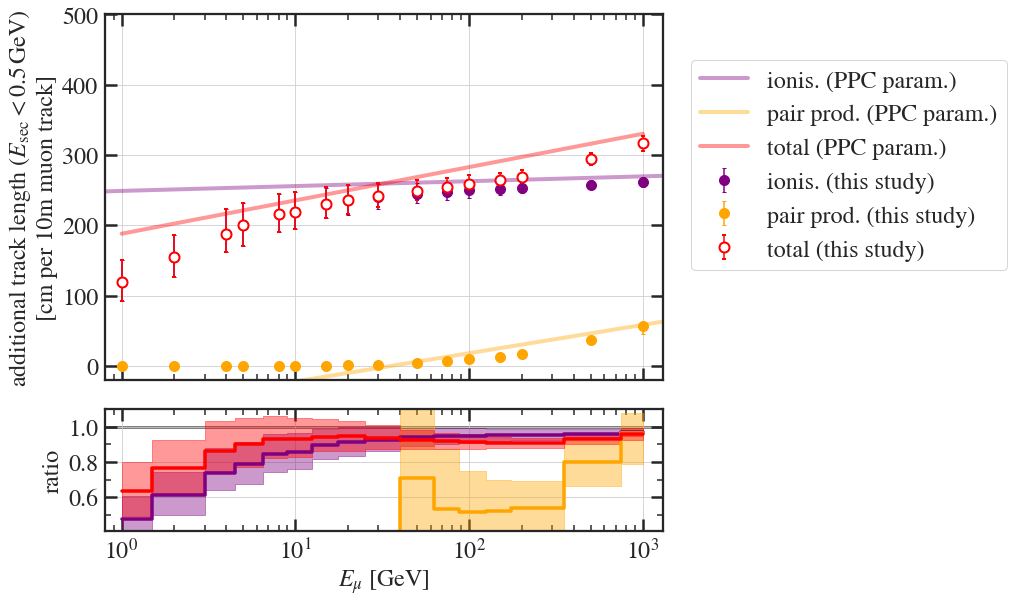

In [113]:
reset_plt(24, 24)
fig, axes = plt.subplots(2, 1, figsize=(10, 9.5), gridspec_kw={'height_ratios': (3, 1)},
                        sharex='col')
ax1, ax2 = axes
ax2.axhline(1, color='gray', lw=3, zorder=-100)

muon_energy_range = np.logspace(-0.5, 3.5, 101)
colors = {'muIoni': 'purple', 'muPairProd': 'orange', 'muBrems': 'pink', 'muonNuclear': 'blue'}
label_alias = {'muIoni': 'ionis.', 'muPairProd': 'pair prod.'}

muon_energies_ioniz = additional_tl_stats['muIoni'][:, 0]
total_current_parametrization = np.zeros_like(muon_energies_ioniz)
total_measured = np.zeros_like(muon_energies_ioniz)
total_upper_error = np.zeros_like(muon_energies_ioniz)
total_lower_error = np.zeros_like(muon_energies_ioniz)

for process in extract_processes[:2]:
    muon_energies = additional_tl_stats[process][:, 0]
    lower, central, upper = additional_tl_stats[process][:, 1:4].T * 1e3
    
    lower_error = central - lower
    upper_error = upper - central
    asymmetric_error = np.array(list(zip(lower_error, upper_error))).T
    
    this_ppc_param = current_parametrization(muon_energy_range, process) * 1e3
    
    ax1.plot(muon_energy_range, this_ppc_param,
           lw=4, alpha=0.4, color=colors[process], label=label_alias[process] + ' (PPC param.)')

    ax1.errorbar(muon_energies, central, yerr = asymmetric_error, ls='None',
               marker='o', capsize=2, markersize=10, color=colors[process],
                label=label_alias[process] + ' (this study)')
    
    interp_current_parametrization = interp1d(muon_energy_range, this_ppc_param)(muon_energies)
    total_measured += central
    
    this_ratio = central / interp_current_parametrization
    ratio_err_lower = lower_error / interp_current_parametrization
    ratio_err_upper = upper_error / interp_current_parametrization
    
    ax2.fill_between(muon_energies, this_ratio-ratio_err_lower, 
                    this_ratio + ratio_err_upper, color=colors[process],
                    step='mid', alpha=0.4)
    ax2.plot(muon_energies, this_ratio, color=colors[process], ds='steps-mid',
            lw=3.5)
    
    total_lower_error += lower_error**2
    total_upper_error += upper_error**2


total_lower_error = np.sqrt(total_lower_error)
total_upper_error = np.sqrt(total_upper_error)
total_asymmetric_error = np.array(list(zip(total_lower_error, total_upper_error))).T
    

total_current_parametrization = current_parametrization(muon_energies, 'total') * 1e3
ax1.plot(muon_energies, total_current_parametrization, color='red', alpha=0.4, lw=4,
        label='total (PPC param.)')
ax1.errorbar(muon_energies, total_measured, yerr=total_asymmetric_error, color='white', markersize=10,
        mec='red', mew=2, ls='none', marker='o', label='total (this study)',
            ecolor='red', capsize=2)

total_ratio = total_measured / total_current_parametrization
total_ratio_lower_error = total_lower_error / total_current_parametrization
total_ratio_upper_error = total_upper_error / total_current_parametrization

ax2.fill_between(muon_energies, total_ratio - total_ratio_lower_error,
                total_ratio + total_ratio_upper_error, color='red', step='mid',
                alpha=0.4)
ax2.plot(muon_energies, total_ratio, color='red', ds='steps-mid', lw=3.5)

    
for ax in axes:
    ax.set_xscale('log')
    ax.grid(True)
    put_ticks(fig, ax)
    
    
# ax1.set_yscale('log')
# ax1.set_ylim(1e-1, 5e2)
ax1.set_ylim(-20, 5e2)

ax1.set_xlim(0.8, 1.3e3)
ax2.set_ylim(0.41, 1.1)

ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax2.set_xlabel(r'$E_{\mu}$ [GeV]')
ax2.set_ylabel('ratio')
ax1.set_ylabel(r'additional track length ($E_{\mathrm{sec}} < 0.5\,\mathrm{GeV}$)' + '\n' + '[cm per 10m muon track]')

ax1.legend(loc=(1.05, 0.3), frameon=True)
fig.subplots_adjust(hspace=0.12)

plt.savefig('../plots/additional_track_length_lin.pdf', bbox_inches='tight')
